**Under construction**

Alexander S. Lundervold, November 13th, 2018.

# Introduction

This notebook and the next is meant to give you a taste of neural networks and deep learning. This is a very large field and the taste will be small. The goal is to perhaps satisfy some of your curiosity ("What is deep learning? How do you *do* deep learning") and point you towards ways to learn more about the topic.

# Setup

In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

import seaborn as sns # For nicer plots

In [3]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

In addition to our standard framework imported above, we'll need both torch and torchvision:

In [4]:
import torch
import torchvision

import torch.nn.functional as F

# Data

We'll use a famous benchmark data set from the computer vision community: <a href="https://www.cs.toronto.edu/~kriz/cifar.html">Cifar-10</a>. 

It consists of 60.000 32x32 color images from 10 different classes:

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

There are 50.000 training images and 10.000 test images. 

<img src="assets/cifar10.png">

## Loading the data into PyTorch

PyTorch (and other deep learning frameworks) operate on what's called **tensors**, which are essentially multidimensional arrays that can be placed on GPUs for accellerated computing. 

To process the Cifar-10 images we need to convert them to tensors:

`utils.py` contains the code used to download the images, normalize them (to improve neural network performance), convert them into tensors, and create data loaders for PyTorch. Take a look if you're curious. 

In [6]:
from utils import get_cifar10, plot_cifar10

Files already downloaded and verified
Files already downloaded and verified


In [7]:
trainloader, testloader = get_cifar10(batch_size=4)

Files already downloaded and verified
Files already downloaded and verified


We can have a look at some images and labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


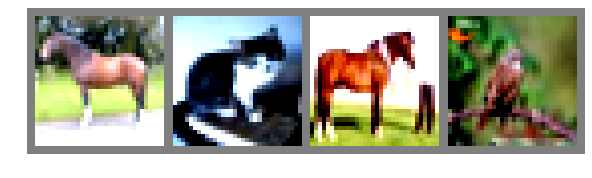

['horse', 'cat', 'horse', 'bird']


In [8]:
plot_cifar10()

# A simple neural network (in PyTorch)

As we discussed in the lecture, there are two stages to training a neural network: a forward pass to get values for all the .., and a backward pass where backpropagation and gradient descent is used to tweak all the weights in the network. 

To make gradient descent work, we need to be able to take the derivative of each component in the network (these derivatives are computed during backpropagation). 

Luckily PyTorch can take care of the differentiation for us (that is, the backward pass) for us if we create a network inheriting from `nn.Module`:

Here's a simple one hidden layer neural network in PyTorch:

In [9]:
input_size = 32*32*3 # The images are 32x32 with three color channels
hidden_size = 84 # We can choose this number

In [10]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        
        super(Net, self).__init__()
        
        # A hidden layer
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        
        # An output layer
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)
        
    # We need to define what we want to happen in the forward phase (the backward phase is automatic)
    
    def forward(self, x):
        
        # Make the 32x32x3 image into a 32*32*3 = 3072 vector
        x = x.view(x.size(0), -1) 
        
        # Feed the input vector through the hidden layer and an activation function
        x = torch.tanh(self.fc1(x)) 
        
        # Output num_classes of numbers.
        # We'll train the network to output a high number for the correct class
        x = self.fc2(x) 
        
        return x

In [11]:
net = Net(input_size = input_size, hidden_size = hidden_size, num_classes = num_classes)

In [12]:
net

Net(
  (fc1): Linear(in_features=3072, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

## Training the network

Remember the steps:
1. Define a neural network (DONE)
2. Collect a batch of training data (we'll use our trainloader)
3. Send these through the network to get its predictions
4. Measure the discrepancy between the true labels and the predictions using a loss function
5. Update all the weights using backpropagation (to calculate the gradients) and gradient descent (to update the weights)

### Training the network on a single batch

In [13]:
# Get the next batch
i, data = next(enumerate(trainloader, 0))

We've now collected the first batch of 4 images:

In [14]:
i

0

In [15]:
images, labels = data

In [16]:
len(images), len(labels)

(4, 4)

The labels of the first four are:

In [17]:
labels

tensor([5, 5, 4, 5])

...which means that the images are of

In [18]:
[classes[label] for label in labels]

['dog', 'dog', 'deer', 'dog']

The images are torch tensors:

In [19]:
images.shape

torch.Size([4, 3, 32, 32])

Four images (batch size), 3 color channels, images of size 32x32. 

#### Feeding the batch to the network

In [20]:
outputs = net(torch.autograd.Variable(images))

In [21]:
outputs.shape

torch.Size([4, 10])

As expected, we got four vectors of length 10. Our goal is to make the element in each vector that corresponds to the correct label for the images in the batch as large as possible, while the rest are small. 

Since we haven't trained our network at all yet, we can't expect it to produce any good predictions:

In [22]:
_, predicted = torch.max(outputs.data, 1)

In [23]:
predicted

tensor([0, 4, 5, 4])

In [24]:
labels

tensor([5, 5, 4, 5])

Chances are none of the predictions are correct. Since we've initialized with completely random weights. 

#### Loss function

We'll use our good friend, cross entropy loss (look back to Part 2 to remind yourself about cross entropy):

In [25]:
criterion = torch.nn.CrossEntropyLoss()

Let's calculate the loss for our current batch: 

In [26]:
loss = criterion(outputs, labels)

In [27]:
loss

tensor(2.6116, grad_fn=<NllLossBackward>)

#### Backpropagation

Using the `backward` method PyTorch can calculate how much each weight in the network contributed to the loss by calculating the gradient of the loss with respect to each of them (using a technique called automatic differentation, which is related to the chain rule you know from MAT108):

In [28]:
loss.backward()

#### Gradient descent

Now we can update all the weights using stochastic gradient descent:

In [29]:
learning_rate = 0.01

In [30]:
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

Take one step with the optimizer to modify each weight:

In [31]:
optimizer.step()

The network has now been trained *a tiny bit* (it has learned from the first four images). 

Let's see if that helped:

In [32]:
outputs = net(torch.autograd.Variable(images))

In [33]:
_, predicted = torch.max(outputs.data, 1)

In [34]:
predicted

tensor([5, 5, 4, 5])

In [35]:
labels

tensor([5, 5, 4, 5])

The network improved (on these four images on which it trained..)

### Going through the training data, batch by batch

The idea now is to repeat this batch by batch, until we've been thriugh the entire training data set multiple times. The idea is that gradient descent will then be able to find good settings for all the weights, which we then can use when new data arrives. 

Let's first create a simple function for checking the accuracy of the network on the test data:

In [36]:
def check_accuracy(net, dataloader=testloader):
        correct = 0
        total = 0
        
        # Feed all the test data through the net and count the number of correct predictions:
        for data in testloader:
            images, labels = data
            outputs = net(torch.autograd.Variable(images))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        
        accuracy = correct.numpy() / total
            
        print('The accuracy of the network on the 10.000 test images is: %d %%' % (100 * accuracy))
        
        return accuracy

Our current accuracy after training on a single batch is

In [37]:
_ = check_accuracy(net)

The accuracy of the network on the 10.000 test images is: 11 %


Since the network is essentially untrained this is as expected (randomly guessing among the 10 classes gives an accuracy of 10%).

Here's the entire procedure for feeding batches through the network. You can CTRL+ENTER this cell to run it multiple times. You'll see the accuracy improve.

In [38]:
learning_rate = 0.001

In [40]:
# Get next batch
i, data = next(enumerate(trainloader, 0))
images, labels = data
# A technicality: we have to zero out the gradients each time, 
# otherwise they'll accumulate
optimizer.zero_grad()
# Collect the outputs
outputs = net(images)
# Compute the loss
loss = criterion(outputs, labels)
print(f'Current loss: {loss}')
# Compute the gradients of the loss with respect to all the weights
loss.backward()
# Update the weights using gradient descent
optimizer.step()
# Compute the current accuracy
_ = check_accuracy(net)

Current loss: 2.2613115310668945
The accuracy of the network on the 10.000 test images is: 17 %


> How many times do you have to run the above cell to go through the entire training data set once? 

Let's make a loop!

We'll go through the entire training set 2 times:

In [41]:
num_epochs = 2

In [42]:
accuracies = []
for epoch in range(num_epochs): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data
        if i % 1000 == 999:    # print every 1000nd batch         
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            
            acc = check_accuracy(net)
            
            print("-"*40)
            accuracies.append(acc)
            running_loss = 0.0

print('Training complete')

[1,  1000] loss: 1.973
The accuracy of the network on the 10.000 test images is: 31 %
----------------------------------------
[1,  2000] loss: 1.866
The accuracy of the network on the 10.000 test images is: 34 %
----------------------------------------
[1,  3000] loss: 1.820
The accuracy of the network on the 10.000 test images is: 36 %
----------------------------------------
[1,  4000] loss: 1.820
The accuracy of the network on the 10.000 test images is: 36 %
----------------------------------------
[1,  5000] loss: 1.801
The accuracy of the network on the 10.000 test images is: 36 %
----------------------------------------
[1,  6000] loss: 1.776
The accuracy of the network on the 10.000 test images is: 38 %
----------------------------------------
[1,  7000] loss: 1.800
The accuracy of the network on the 10.000 test images is: 37 %
----------------------------------------
[1,  8000] loss: 1.778
The accuracy of the network on the 10.000 test images is: 37 %
-------------------------

We can plot the accuracy changes during training:

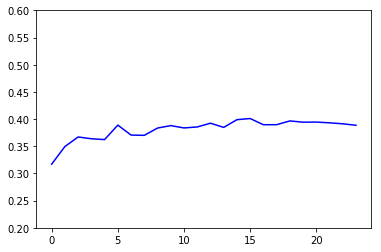

In [43]:
plt.ylim([0.2, 0.6])
plt.plot(accuracies, 'b')
plt.show()

We see that we quickly reach what seems to be a plateau in accuracy. We need something else to go beyond 40%...

> **That's it**, basically! Now you know some of the basics of training a neural network!

However, our above neural network is not particularly powerful. We can do much, much better...

> **Your turn!** Try adding a second hidden layer to the network. How does it influence performance? Try experimenting with the sizes of the hidden layers. Are you able to obtain a better result than above?

> Note: if you remove the "check_accuracy" call in the training loop it'll speed up the training.

# Deep learning

Fundamentally, "deep learning" for neural networks simply means adding more than one hidden layer: i.e. making the network deep. When you did the above "Your turn!" exercise, you actually did deep learning.

However, "deep learning" also refers to an entire field of research, chock-full of exciting ideas, models and techniques. 

It's an extremely hot field that exploded a few years ago and is still growing. See the lecture slides for more background story. 

<img width="50%" src="assets/exponential.png">

We only have time for a tiny, tiny taste here, unfortunately, but we'll get a taste of the state-of-the-art in deep learning.

One of the areas where it has had the most impact is in **computer vision**, for example in **image classification**. In image classification the task is to assign an image to the correct class. If it's an image of a dog, it should be assigned to class "dog". 

That's exactly what we did above, using the Cifar-10 data set. 

However, our approach&ndash;and therefore our accuracy&ndash; was pretty bad compared to what one can achieve. The most poweful types of neural networks for image analysis are the so-called *convolutional neural networks*. These are the most famous deep learning models out there. 

## Convolutional neural networks

The lecture gave you some intuition for convolutional neural networks. Let's try to build one.

<img src="assets/cnn.png"><br>
<center><small>Image from Sean Murray</small></center>

Note that we won't be able to go into details about CNNs. Feel free to ask Alexander or the teaching assistants if you want to learn more!

> In the next notebook we'll use a state-of-the-art network that'll outperform all our models on Cifar-10 by a huge margin (and in fact be close to the best result ever recorded on the benchmark data set Cifar-10). However, this will require a powerful GPU.

In [44]:
# Selecting some parameters for the model
kernel_size = 5
out_channels = [6, 16]
fc_features = [120, 84]

In [45]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolution and pooling:
        self.conv1 = torch.nn.Conv2d(in_channels=3, 
                                     out_channels=out_channels[0], 
                                     kernel_size=kernel_size)
        
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=out_channels[0], 
                                     out_channels=out_channels[1], 
                                     kernel_size=kernel_size)
        
        
        # The fully-connected layers at the end:
        self.fc1 = torch.nn.Linear(in_features=out_channels[1] * kernel_size * kernel_size, 
                                   out_features=fc_features[0])
        
        self.fc2 = torch.nn.Linear(in_features=fc_features[0], 
                                   out_features=fc_features[1])
        
        # Output layer:
        self.fc3 = torch.nn.Linear(in_features=fc_features[1], 
                                   out_features=10)
        
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        
        x = x.view(-1, out_channels[1] * kernel_size * kernel_size)
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [46]:
cnn = CNN()

In [47]:
cnn

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [48]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [49]:
num_epochs = 2

In [50]:
for epoch in range(num_epochs): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data
        if i % 1000 == 999:    # print every 1000nd batch         
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Training complete')

_ = check_accuracy(cnn)

[1,  1000] loss: 2.169
[1,  2000] loss: 1.885
[1,  3000] loss: 1.746
[1,  4000] loss: 1.663
[1,  5000] loss: 1.609
[1,  6000] loss: 1.554
[1,  7000] loss: 1.541
[1,  8000] loss: 1.512
[1,  9000] loss: 1.486
[1, 10000] loss: 1.445
[1, 11000] loss: 1.446
[1, 12000] loss: 1.414
[2,  1000] loss: 1.365
[2,  2000] loss: 1.349
[2,  3000] loss: 1.346
[2,  4000] loss: 1.351
[2,  5000] loss: 1.330
[2,  6000] loss: 1.324
[2,  7000] loss: 1.324
[2,  8000] loss: 1.290
[2,  9000] loss: 1.296
[2, 10000] loss: 1.269
[2, 11000] loss: 1.304
[2, 12000] loss: 1.297
Training complete
The accuracy of the network on the 10.000 test images is: 55 %


> **Your turn!** Try playing with the parameters we chose for our CNN. The kernel_size, the number of output channels (which is the *width* of the network) etc. You can also try adding another convolutional layer to the network to check whether that improves the  result (Hint: it does). However, the training time will increase as you increase the amount of parameters. 

In [51]:
# Number of trainable parameters:
#sum(p.numel() for p in cnn.parameters() if p.requires_grad)

> If you want to make a really big and powerful model, you'll have to use a GPU.. Ask Alexander or the TAs for more details!

### Confusion matrix

As we remember from Part 2, when doing classification the *confusion matrix* is a very useful tool.

First we collect lists of the predicted labels for the test data and the true labels:

In [52]:
y_pred = []
y_true = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(list(predicted.numpy()))
        y_true.append(list(labels.numpy()))
        

In [53]:
# Flatten the lists (they are lists of sublists of length batch size)
y_pred = [i for sublist in y_pred for i in sublist]
y_true = [i for sublist in y_true for i in sublist]

In [54]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

In [55]:
cm = confusion_matrix(y_true, y_pred)

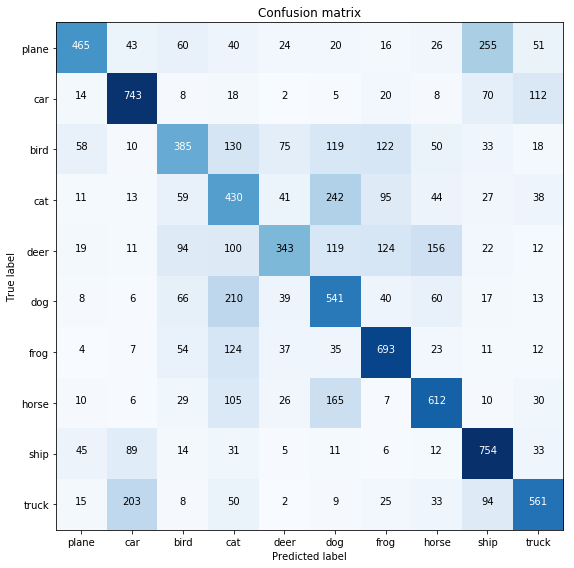

In [56]:
fig, ax = plt.subplots(figsize=(16,8))
_ = plot_confusion_matrix(cm, classes=classes, ax=ax)

In the next notebook we'll construct a much better CNN, way outperforming the above, very simple CNN. 

# Your turn!

> **Your turn!** Train both a fully-connected neural network and a convolutional neural network to recognize the handwritten digits in the MNIST data set. Compare your result with what we got using SGDClassifier and random forests back in Part 2.

**Hints:**
- When loading the data (look into `utils.py` to see how), normalize the images using `transforms.Normalize((0.1307,), (0.3081,)`
- Since the MNIST images are 28x28 set the input size to `28*28`
- Remember to point the optimizer at your new MNIST network. 
- Ask for assistance if you get stuck!